In [ ]:
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import pandas as pd
import requests
from urllib.request import Request, urlopen
import json
import re
import glob
import os
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
from decimal import Decimal
import math
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy import misc
from matplotlib.colors import ListedColormap
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model, metrics, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from IPython.display import Image, display  
from collections import Counter
import pydotplus 

warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)

# Web Scraping

## Selenium Infinite Scrolling

In [ ]:
html_companies_page = 'https://finder.startupnationcentral.org/startups/search'

In [ ]:
def get_driver():
    driver = webdriver.Chrome(executable_path=r"C:\Users\user\Desktop\Jupyter\startup exploit\chromedriver.exe")
    driver.get(html_companies_page)
    return driver

In [ ]:
# Use selenium to implement infinite scroll so we can get all companies urls and scrape data from the page

def infinite_scroll(driver):
    time.sleep(2)  # Allow 2 seconds for the web page to open
    scroll_pause_time = 1 
    screen_height = driver.execute_script("return window.screen.height;")   # get the screen height of the web
    i = 2
    while (i < 50):
        # scroll one screen height each time
        driver.execute_script("window.scrollTo(0, {screen_height}*{i});".format(screen_height=screen_height, i=i))  
        i += 1
        time.sleep(scroll_pause_time)
        scroll_height = driver.execute_script("return document.body.scrollHeight;")  

In [ ]:
driver = get_driver()

In [ ]:
infinite_scroll(driver)

In [ ]:
#use linkedin account to login
driver = get_driver()

log_in_button = driver.find_element(By.ID'menulogin')
log_in_button.click()

username = driver.find_element(By.ID, 'login-email')
username.send_keys('s2132542@siswa.um.edu.my')

time.sleep(0.5)

password = driver.find_element(By.ID, 'password')
password.send_keys('Coffeecode0610~')

time.sleep(0.5)

log_in_button = driver.find_element(By.ID'menulogin')
log_in_button.click()

time.sleep(3)

# Get Companies URLs

In [ ]:
def load_soup_object(html_file_name):
    html = open( html_file_name, encoding="utf8")
    soup = BeautifulSoup(html, 'html.parser')
    return soup

In [ ]:
def extract_companies_urls(html_link):
    html_link = "./Data/companies_urls/" + html_link
    soup = load_soup_object(html_link)
    companie_div = soup("div",attrs = {"class" : 'js-company-cards-list'})[0]
    links = list()
    for row in companie_div('div',attrs = {"class" : 'box-view-item'}):
        url = row('a')[0]['href']
        links.append(url)
    return links

In [ ]:
list_50_to_90 = extract_companies_urls('Start-Up1950-1990.html')
list_91_to_00 = extract_companies_urls('Start-Up1991-2000.html')
list_01_to_05 = extract_companies_urls('Start-Up2001-2005.html')
list_05_to_09 = extract_companies_urls('Start-Up2005-2009.html')
list_10_to_11 = extract_companies_urls('Start-Up2010-2011.html')
list_12 = extract_companies_urls('Start-Up2012.html')
list_13 = extract_companies_urls('Start-Up2013.html')
list_14 =extract_companies_urls('Start-Up2014.html')
list_15 = extract_companies_urls('Start-Up2015.html')
list_16 = extract_companies_urls('Start-Up2016.html')
list_17 = extract_companies_urls('Start-Up2017.html')
list_18 = extract_companies_urls('Start-Up2018.html')
list_19 = extract_companies_urls('Start-Up2018.html')
list_20_22 = extract_companies_urls('Start-Up2020-2022.html')

In [ ]:
df = pd.DataFrame({'links' : link_list})

In [ ]:
df = df.drop_duplicates().copy()

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
df.to_csv("companies_urls.csv",index = False)

# Company Page Scraping

In [ ]:
def load_csv(fileName):
    return pd.read_csv(fileName)

In [ ]:
def load_soup_html(url):    
    html = requests.get(url)
    soup = BeautifulSoup(html.text, 'html.parser')
    return soup

## Load URLs CSV from previous stage

In [ ]:
df = load_csv("companies_urls.csv")

## Define a function that extracts all of the features we want from the company page :

In [ ]:
def get_df_companies(df):
    res_df = pd.DataFrame(columns=['COMPANIE_NAME', 'FOUNDED', 'BUSINESS_MODEL', 'EMPLOYEES','FUNDING_STAGE','RAISED'
                                   , 'PRODUCT_STAGE', 'NEWS_COUNT', 'FOUNDER_COUNT', 'TOTAL_ROUNDS', 'INVESTORS_COUNT'
                                   , 'COMPANY_STATUS', 'IS_ACADEMIC', 'SECTOR', 'TARGET_INDUSTORY'])
    for url in df['links']:
        print(url)
        soup = load_soup_html(url)
        
        company_dict = {
            "NAME": None,
            "FOUNDED": None,
            "BUSINESS MODEL": None,
            "EMPLOYEES": None,
            "FUNDING STAGE": None,
            "RAISED": 0,
            "PRODUCT STAGE": None,
            "NEWS": 0,
            "FOUNDERS": 0,
            "Total rounds": 0,
            "Investors": 0,
            "STATUS": "Active",
            "IS ACADEMIC": 0,
            "SECTOR": None,
            "TARGET INDUSTORY": None
        }
        
        name_div = soup("div",attrs = {"class" : 'top-profile-section'})
        if(not name_div):
            continue
            
        company_dict["NAME"] = soup("div",attrs = {"class" : 'top-profile-section'})[0]("div",attrs = {"class" : 'title'})[0].get_text().strip()

        COMPANY_PROFILE = soup("div",attrs = {"class" : 'metadata-wrapper'})
        if(len(COMPANY_PROFILE)):
            for div in COMPANY_PROFILE[0]("div",attrs = {"class" : 'item-bottom'}):
                company_dict.update( {div.get_text().strip(): div.find_previous('div').get_text().strip()})
            
        if(soup("div", attrs = {"id": "news-section"})):
            news_div = soup("div", attrs = {"id": "news-section"})[0]
            news_str = news_div("div", attrs = {"class": "section-text"})[0].get_text().strip()
            company_dict["NEWS"] = int(re.findall('\d+', news_str)[0])
            
        if(soup("div", attrs = {"id": "team-section"})):
            team_div = soup("div", attrs = {"id": "team-section"})[0]
            team_str = team_div("div", attrs = {"class": "section-text"})[0].get_text().strip()
            company_dict["FOUNDERS"] = int(re.findall('\d+', team_str)[0])
         
        FUNDING_DATA = soup("div",attrs = {"class" : 'funding-metadata'})
        if(len(FUNDING_DATA)):
            for div in FUNDING_DATA[0]("div",attrs = {"class" : 'subtitle'}):
                funding_text = div.get_text().strip()
                if(funding_text == 'Total rounds' or funding_text == 'Investors'):
                    company_dict[funding_text] = div.find_previous('div').get_text().strip()

        if(soup.find_all("div", string=["Public"])):
            company_dict["STATUS"] = "Public"
        elif(soup.find_all("div", string=["Acquired by"])):
            company_dict["STATUS"] = "Acquired"
        elif(soup.find_all("div", string=["Not Active"])):
            company_dict["STATUS"] = "Not Active"
            
        if(soup.find_all("div", string=["Academic technology"])):
            company_dict["IS ACADEMIC"] = 1
            
        sector_div = soup.find_all("use", attrs={"xlink:href": "#icon-classification-sector"})
        if(sector_div):
            sector_div = sector_div[0].parent.parent.parent.parent("a", attrs = {"class": "lead-title"})
            company_dict["SECTOR"] = sector_div[0].get_text().strip()
        
        industry_div = soup.find_all("use", attrs={"xlink:href": "#icon-classification-industry"})
        if(industry_div):
            industry_div = industry_div[0].parent.parent.parent.parent("a", attrs = {"class": "lead-title"})
            company_dict["TARGET INDUSTORY"] = industry_div[0].get_text().strip()
        
        print(company_dict)
        res_df.loc[len(res_df)] = list(company_dict.values())
        
    return res_df


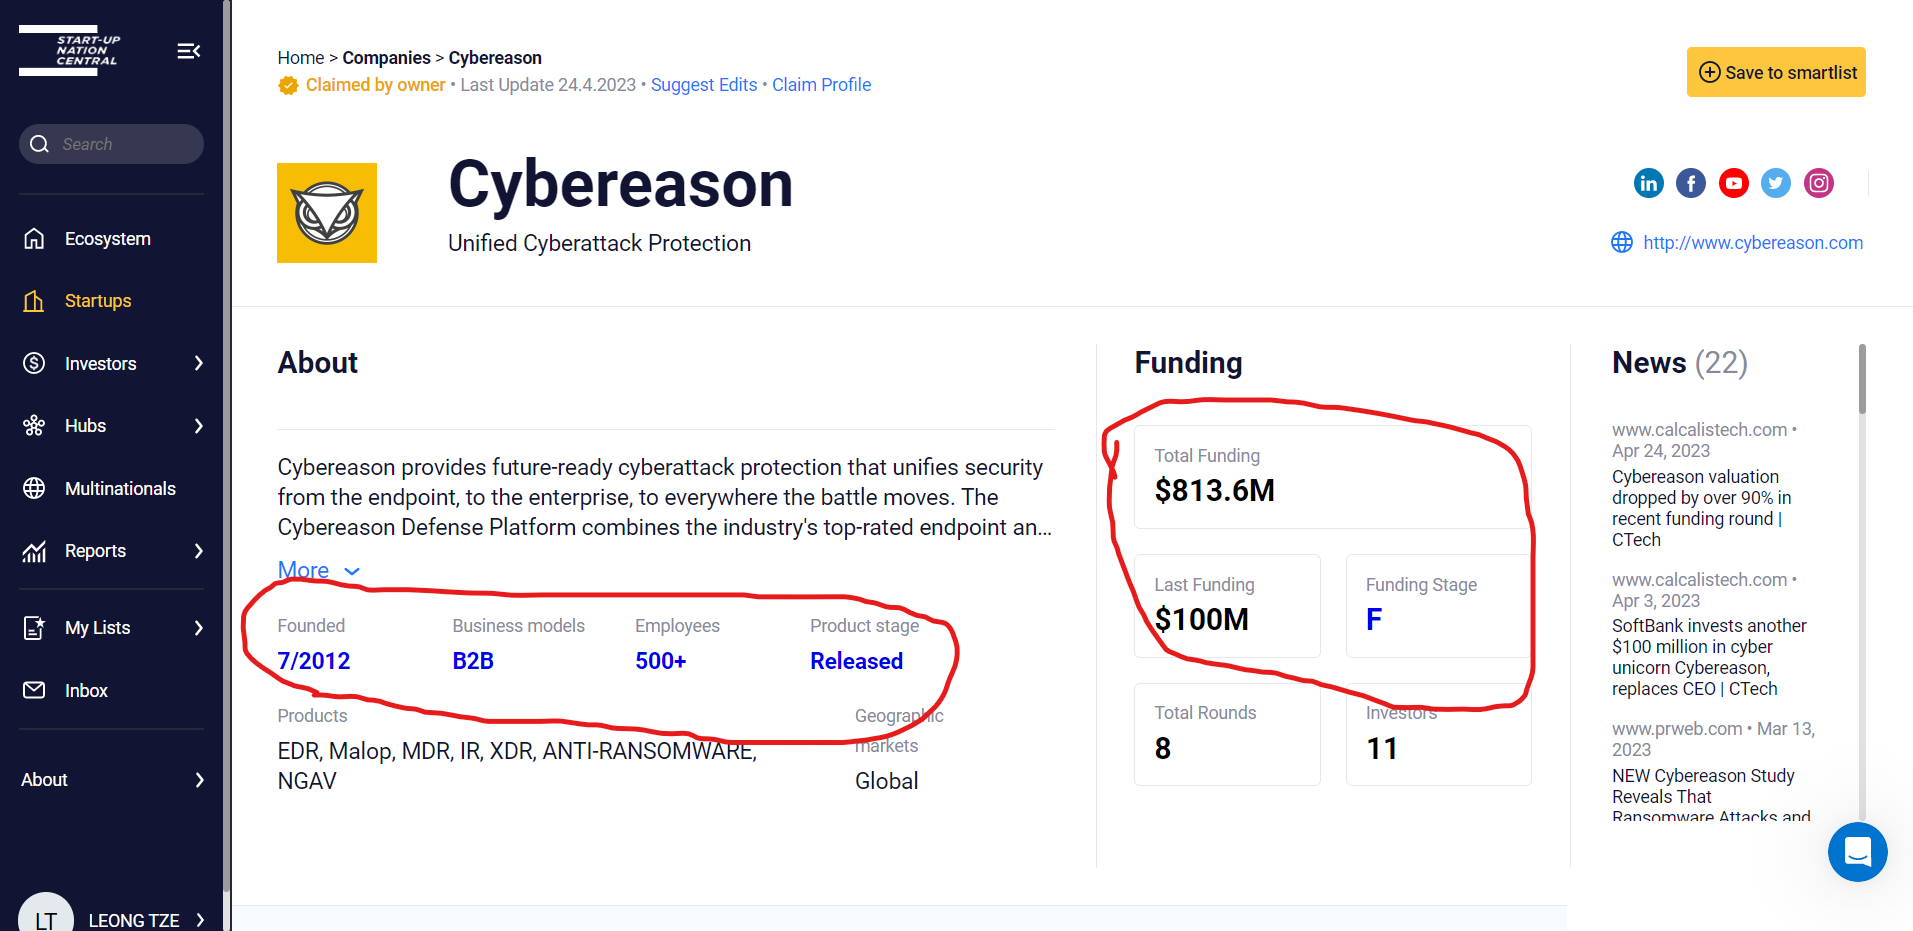

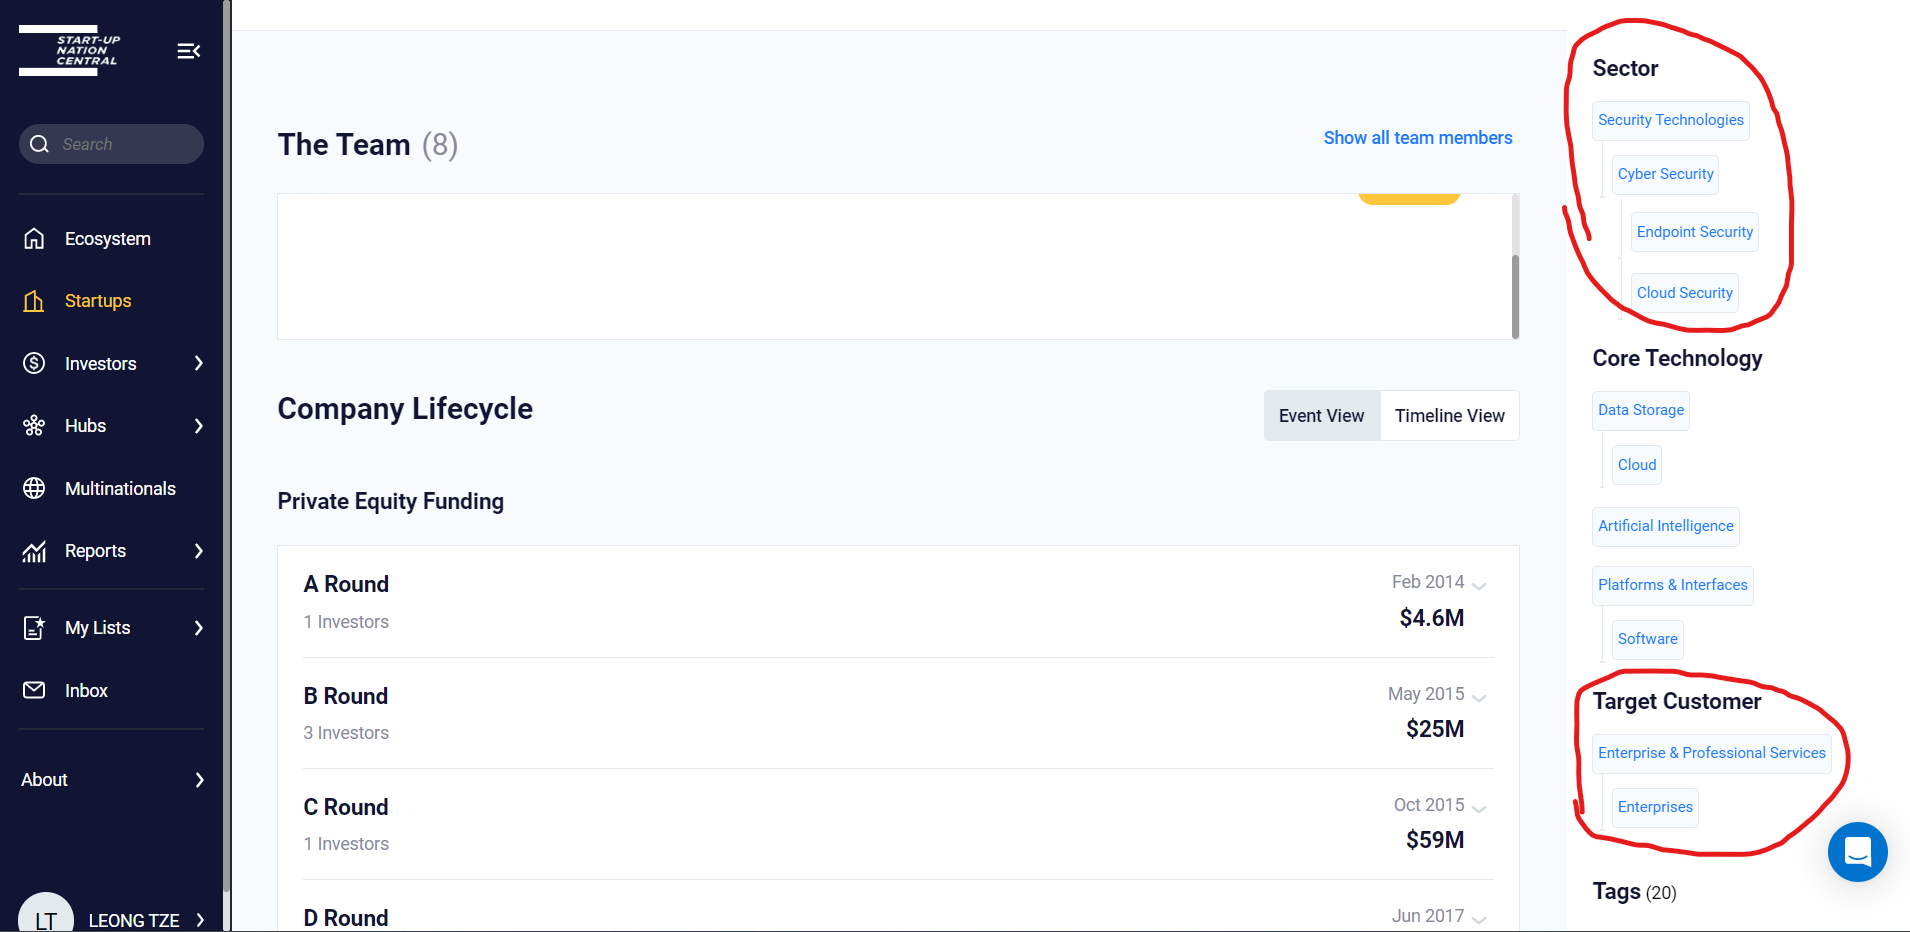

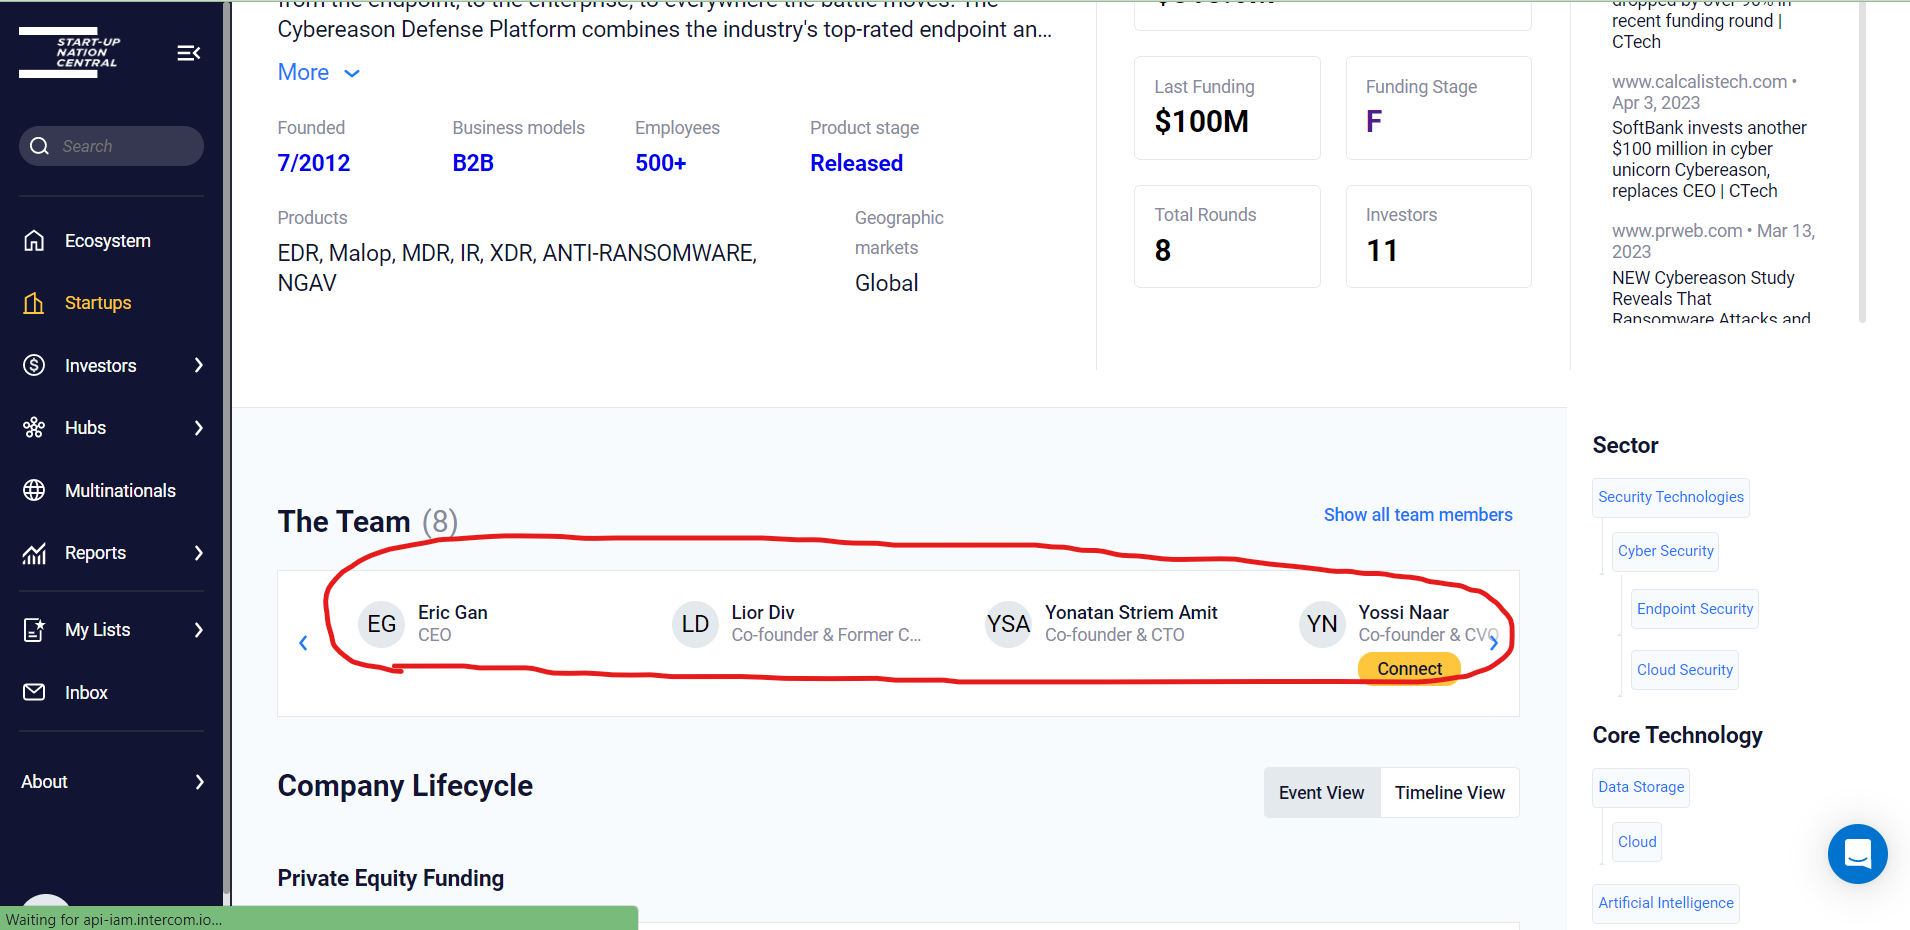

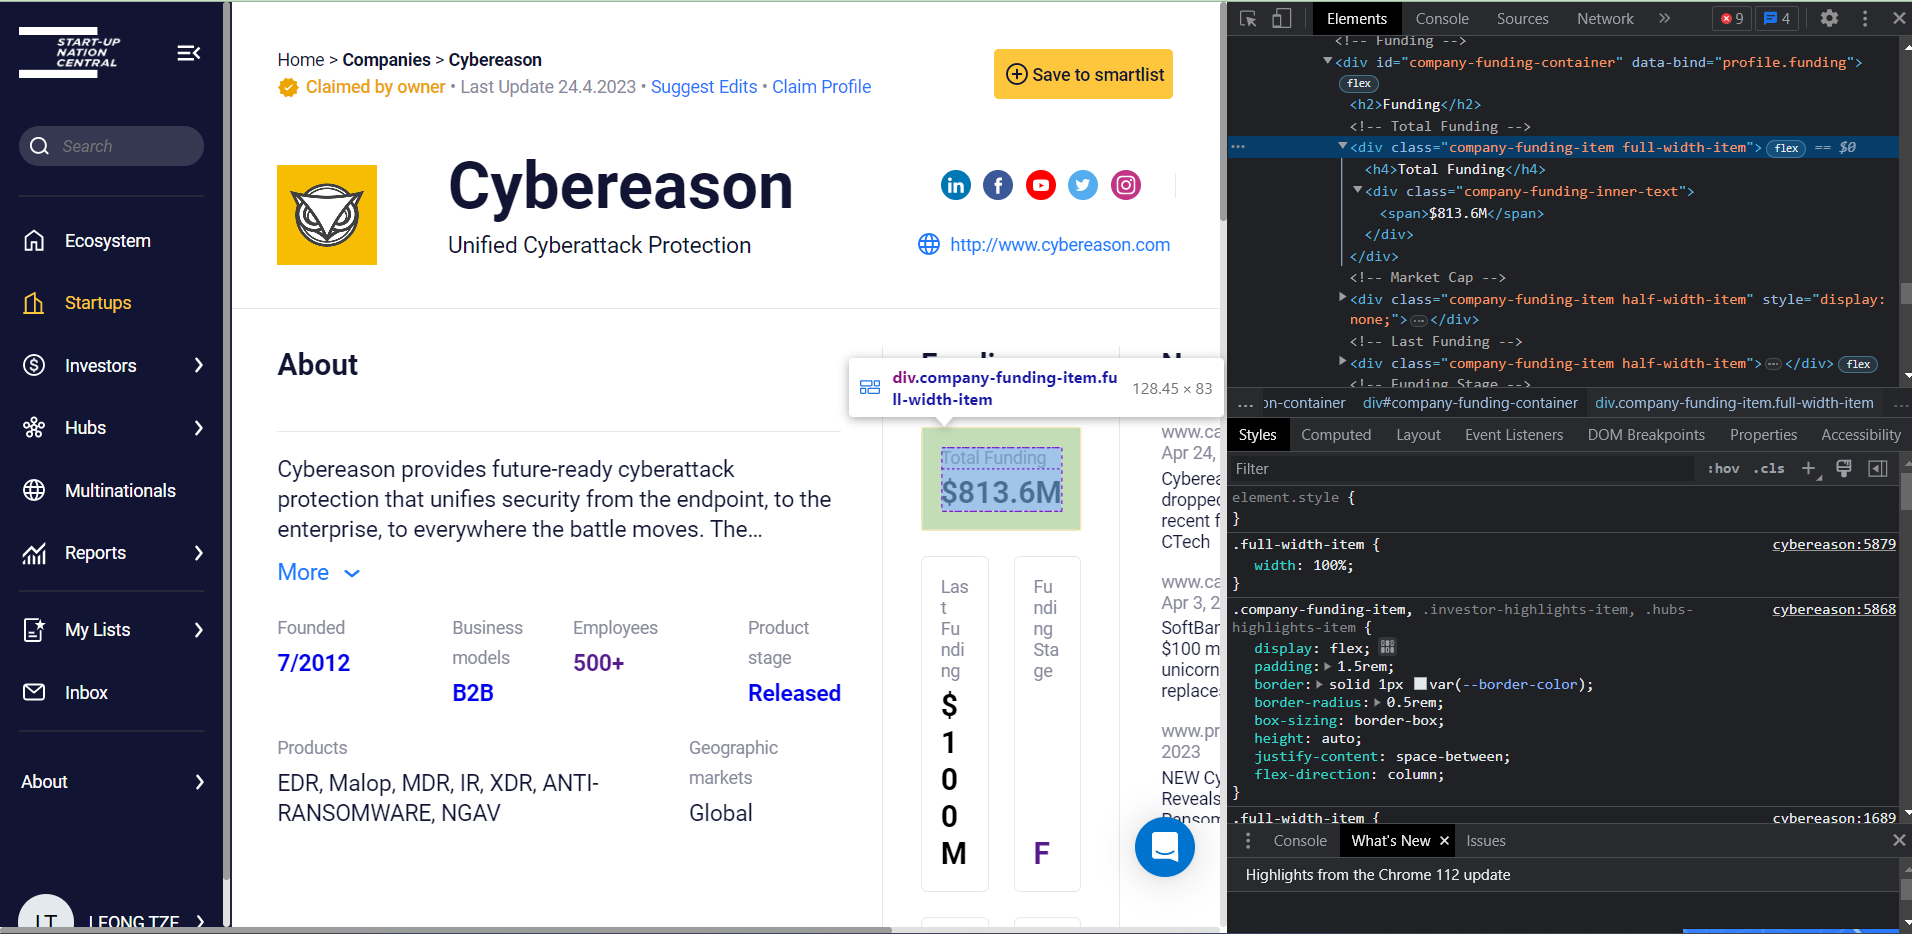

### Now, we are going run in a loop, each iteration will include 100 companies data extracting and we will wait a few seconds so we wont get blocked.
### Each iteration is saved in a seperate DataFrame so we can be in control all the time and check the data we are getting. (this step lasted for hours)

In [ ]:
for i in range(0,104):
    df_res = get_df_companies(df.iloc[i*100: (i+1) * 100])
    df_res.to_csv("Data\companies_df\companies_" + str(i*100) + "-" + str((i*100) + 99) + ".csv",index = False)
    print("************************ file number:" + str(i) + "***********************\n\n")
    time.sleep(10)

### Combine all the files to one big DataFrame after finished scraping:

In [ ]:
path = r'Data\companies_df'
all_files = sorted(glob.glob(os.path.join(path, "*.csv")), key=os.path.getmtime) #get all files sorted by time modified asc 

df_from_each_file = (pd.read_csv(f) for f in all_files)
concatenated_df = pd.concat(df_from_each_file, ignore_index=True)
# concatenated_df

In [ ]:
filepath = r'Data\companies_df\main_df.csv'
concatenated_df.to_csv(filepath, index=False)

## Data cleaning

In [ ]:
main_df = pd.read_csv('Data/companies_df/main_df.csv')

In [ ]:
main_df

### First, Let's look at none values for our companies. We can see that we have up to 709 None values in some columns, so we will start our data cleaning by using dropna.

In [ ]:
main_df.isnull().sum(axis = 0)

COMPANIE_NAME         0
<br>
FOUNDED             376
<br>
BUSINESS_MODEL      467
<br>
EMPLOYEES           408
<br>
FUNDING_STAGE       709
<br>
RAISED                0
<br>
PRODUCT_STAGE       569
<br>
NEWS_COUNT            0
<br>
FOUNDER_COUNT         0
<br>
TOTAL_ROUNDS          0
<br>
INVESTORS_COUNT       0
<br>
COMPANY_STATUS        0
<br>
IS_ACADEMIC           0
<br>
SECTOR              343
<br>
TARGET_INDUSTORY    394
<br>
dtype: int64

In [ ]:
main_df.dropna(inplace=True)
print(main_df.isnull().sum(axis = 0))
print(len(main_df))

### Transform RAISED value (total fundings) into numeric from string to int when we consider the meaning of 'K', 'M', 'B'

In [ ]:
d = {'K': 3,'M': 6,'B': 9}
def text_to_num(text):
    if text == '0':return 0
    if text[-1] in d:
        num, magnitude = text[1:-1], text[-1]
        return int(float(num) * 10 ** d[magnitude])
    else:
        return int(0)

In [ ]:
for idx, row in main_df.iterrows():
    raised = text_to_num(row['RAISED'])
    main_df.at[idx,'RAISED'] = raised

In [ ]:
main_df["RAISED"] = pd.to_numeric(main_df["RAISED"])
main_df["RAISED"].describe().apply(lambda x: format(x, 'f'))

### Extract month and year from 'FUNDED' feature which looks like this "10/2021". Separate month and year from each string and push them into dataframe

In [ ]:
def extract_month_and_year(val):
    lst = val.split('/')
    if len(lst) == 1:
        lst.insert(0,0)
    return int(lst[0]),int(lst[1])


In [ ]:
months = list()
years = list()
for idx, row in main_df.iterrows():
    month,year = extract_month_and_year(row['FOUNDED'])
    months.append(month)
    years.append(year)
main_df.insert(loc=2, column='FOUNDED_MONTH', value=months) 
main_df.insert(loc=3, column='FOUNDED_YEAR', value=years) 
main_df.drop(columns = ['FOUNDED'], axis=1, inplace=True)

In [ ]:
main_df.describe()

### Now we have categorical feature 'BUSINESS_MODEL' that we want to transform to numeric true\false columns :
### Buisness model feature has 4 possible categories when there are companies that are characterized by several different models.

In [ ]:
def extract_business_model(main_df):
    b2b = list()
    b2c = list()
    b2g = list()
    b2b2c = list()
    for model in main_df['BUSINESS_MODEL']:
        lst = model.split(', ')
        b2b.append('B2B' in lst)
        b2c.append('B2C' in lst)
        b2g.append('B2G' in lst)
        b2b2c.append('B2B2C' in lst)
            
    return b2b, b2c, b2g ,b2b2c
    
    

In [ ]:
b2b, b2c, b2g ,b2b2c = extract_business_model(main_df)
main_df.insert(loc=4, column='B2B', value=b2b) 
main_df.insert(loc=5, column='B2C', value=b2c) 
main_df.insert(loc=6, column='B2G', value=b2g) 
main_df.insert(loc=7, column='B2B2C', value=b2b2c) 

In [ ]:
main_df['B2B'] = np.where(main_df['B2B'],1,0)
main_df['B2C'] = np.where(main_df['B2C'],1,0)
main_df['B2G'] = np.where(main_df['B2G'],1,0)
main_df['B2B2C'] = np.where(main_df['B2B2C'],1,0)
main_df.drop(columns = ['BUSINESS_MODEL'], axis=1, inplace=True)

'COMPANY_STATUS' is also categorical feature and we want to transform it to numeric true\false columns :

In [ ]:
def extract_company_status(main_df):
    is_public = list()
    is_acquired = list()
    is_active = list()
    is_notActive = list()
    for status in main_df['COMPANY_STATUS']:
        is_public.append('Public' == status)
        is_acquired.append('Acquired' == status)
        is_active.append('Active' == status)
        is_notActive.append('Not Active' == status)
    
    is_public = np.where(is_public,1,0)
    is_acquired = np.where(is_acquired,1,0)
    is_active = np.where(is_active,1,0)
    is_notActive = np.where(is_notActive,1,0)
    
    return is_public, is_acquired, is_active ,is_notActive

In [ ]:
is_public, is_acquired, is_active ,is_notActive = extract_company_status(main_df)
main_df.insert(loc=16, column='IS_PUBLIC', value=is_public) 
main_df.insert(loc=17, column='IS_ACQUIRED', value=is_acquired) 
main_df.insert(loc=18, column='IS_ACTIVE', value=is_active) 
main_df.insert(loc=19, column='IS_NOT_ACTIVE', value=is_notActive)
main_df.drop(columns = ['COMPANY_STATUS'], axis=1, inplace=True)

In [ ]:
main_df

In [ ]:
main_df.describe(include='all')

### We realized that 'IS_ACADEMIC' value is 0 for all the rows at this point, so we decided to drop the entire column.

In [ ]:
print("Number of companies with IS_ACADEMIC = True :  ",sum(main_df['IS_ACADEMIC']==1))
main_df.drop(columns = ['IS_ACADEMIC'], axis=1, inplace=True)

In [ ]:
Number of companies with IS_ACADEMIC = True :   0

### 'FUNDING_STAGE', 'EMPLOYEES' and 'PRODUCT_STAGE' are categorical features and we want to convert their values to numeric categories
### Let's look at our unique values :

In [ ]:
print(main_df['FUNDING_STAGE'].unique())
print(main_df['EMPLOYEES'].unique())
print(main_df['PRODUCT_STAGE'].unique())

In [ ]:
['Public' 'Revenue Financed' 'Established' 'ROUND A' 'ROUND C+' 'Acquired'
 'Seed' 'ROUND B' 'Bootstrapped' 'Pre-Seed']
['11-50' '1-10' '500+' '201-500' '51-200']
['Released' 'Clinical Trial' 'R&D' 'Beta' 'Alpha' 'Customer development']

### Acquired is not a funding stage, therefore we need to drop 8 records where funding stage = acquired

In [ ]:
len(main_df[main_df['FUNDING_STAGE'] == 'Acquired'].index)

In [ ]:
main_df.drop(main_df[main_df.FUNDING_STAGE == 'Acquired'].index, inplace=True)

### Because these features are ordinal categorical we want to order them by numerical order :

In [ ]:
employees_replace_map = {'1-10': 0, '11-50': 1, '51-200': 2, '201-500': 3, '500+': 4}
main_df['EMPLOYEES'].replace(employees_replace_map, inplace=True)

funding_replace_map = {'Bootstrapped': 0, 'Pre-Seed': 1, 'Seed': 2, 'ROUND A': 3, 'ROUND B': 4, 'ROUND C+': 5, 'Public': 6, 'Revenue Financed': 7, 'Established': 8}
main_df['FUNDING_STAGE'].replace(funding_replace_map, inplace=True)

stage_replace_map = {'Customer development': 0, 'R&D': 1, 'Clinical Trial': 2, 'Alpha': 3, 'Beta': 4, 'Released': 5}
main_df['PRODUCT_STAGE'].replace(stage_replace_map, inplace=True)

### 'SECTOR' and 'TARGET_INDUSTORY' are not ordinal categorical so we can give them codes in any order.

In [ ]:
sector_replace_map = dict( enumerate(main_df['SECTOR'].astype('category').cat.categories ))
main_df['SECTOR'].replace(sector_replace_map, inplace=True)
print(sector_replace_map)
target_replace_map = dict( enumerate(main_df['TARGET_INDUSTORY'].astype('category').cat.categories ))
main_df['TARGET_INDUSTORY'].replace(target_replace_map, inplace=True)
print(target_replace_map)


In [ ]:
{0: 'Aerospace & Aviation', 1: 'AgriFood-tech & Water', 2: 'Content & Media', 3: 'Energy-tech', 4: 'Enterprise, IT & Data Infrastructure', 5: 'FinTech', 6: 'Industrial Technologies', 7: 'Life Sciences & HealthTech', 8: 'Retail & Marketing', 9: 'Security Technologies', 10: 'Smart Mobility'}
{0: 'Agriculture & Food', 1: 'Commerce & Retail', 2: 'Communication Services', 3: 'Consumers', 4: 'Defense, Safety & Security', 5: 'Education', 6: 'Energy, Utilities & Waste Management', 7: 'Enterprise & Professional Services', 8: 'Financial Services', 9: 'Food Retail & Consumption', 10: 'Government & City', 11: 'Healthcare & Life Sciences', 12: 'Industrial Manufacturing', 13: 'Media & Entertainment', 14: 'Real Estate & Construction', 15: 'Transportation & Logistics', 16: 'Travel & Tourism'}

In [ ]:
def get_age(year_list, month_list):
    age = list()
    for year, month in zip(year_list, month_list):
        age.append((2022 - year) * 365 + (6 - month) * 30)
    return age

### We see that we have some months with 0 value so we will replace them with the mean value.

In [ ]:
main_df.loc[main_df['FOUNDED_MONTH'] == 0, ['FOUNDED_MONTH']] = round(main_df['FOUNDED_MONTH'].mean())

### And now lets add 'AGE' feature which means how old the company is in days.

In [ ]:
age = get_age(main_df['FOUNDED_YEAR'], main_df['FOUNDED_MONTH'])
main_df.insert(loc=3, column='AGE', value=age) 

In [ ]:
main_df

# Outliers

####

In this secion, we are going to:

Detect Outliers and present them by using boxplots for the next features:
RAISED
NEWS_COUNT
FOUNDER_COUNT
INVESTORS_COUNT
We are going to use Z-score and IQR and select what seems best for us.

###

In [ ]:
sns.boxplot(main_df.RAISED)
plt.show()
sns.boxplot(main_df.NEWS_COUNT)
plt.show()
sns.boxplot(main_df.FOUNDER_COUNT)
plt.show()
sns.boxplot(main_df.INVESTORS_COUNT)
plt.show()

### 'RAISED'

In [ ]:
Q1 = np.percentile(main_df["RAISED"], 25)
Q3 = np.percentile(main_df["RAISED"], 75)
IQR = Q3 - Q1
print(f"IQR value: {IQR}\nQ1 value: {Q1}\nQ3 value: {Q3}")
Fare_outlier_rows = main_df[(main_df["RAISED"] < Q1 - 1.5*IQR) | (main_df["RAISED"] > Q3 + 1.5*IQR )].index
print("Total sum of outliers detected: ",len(Fare_outlier_rows))

### With IQR we got 1763 outliers which is too many, hence we try z-score:

In [ ]:
z_score = (main_df["RAISED"] - main_df["RAISED"].mean()) / main_df["RAISED"].std()
outliers = abs(z_score) > 3
print("Total outliers: ", sum(outliers))
main_df.drop(main_df[outliers].index, axis=0, inplace=True)
print("110 outliers are much better for us so we will use z-score")

# NEWS_COUNT

In [ ]:
z_score = (main_df["NEWS_COUNT"] - main_df["NEWS_COUNT"].mean()) / main_df["NEWS_COUNT"].std()
outliers = abs(z_score) > 4
print("Total outliers: ", sum(outliers))
main_df.drop(main_df[outliers].index, axis=0, inplace=True)

# 'FOUNDER_COUNT'

In [ ]:
z_score = (main_df["FOUNDER_COUNT"] - main_df["FOUNDER_COUNT"].mean()) / main_df["FOUNDER_COUNT"].std()
outliers = abs(z_score) > 4
print("Total outliers: ", sum(outliers))
main_df.drop(main_df[outliers].index, axis=0, inplace=True)

# 'INVESTORS_COUNT'

In [ ]:
z_score = (main_df["INVESTORS_COUNT"] - main_df["INVESTORS_COUNT"].mean()) / main_df["INVESTORS_COUNT"].std()
outliers = abs(z_score) > 4
print("Total outliers: ", sum(outliers))
main_df.drop(main_df[outliers].index, axis=0, inplace=True)

In [ ]:
sns.boxplot(main_df.RAISED)
plt.show()
sns.boxplot(main_df.NEWS_COUNT)
plt.show()
sns.boxplot(main_df.FOUNDER_COUNT)
plt.show()
sns.boxplot(main_df.INVESTORS_COUNT)
plt.show()

### We can see that our outliers graph for numeric columns are much better now!
Data cleaning is finished, le'ts fix our indexes and save the final data frame.
###

In [ ]:
main_df.reset_index(inplace=True)
main_df

In [ ]:
main_df.to_csv('Data/companies_df/clean_df.csv', index=False)

# EDA 📊📈📉

In [ ]:
df = pd.read_csv('Data/companies_df/clean_df.csv')

In [ ]:
df_raised_money = df[df['RAISED'] > 0]
df_didnt_raised_money = df[df['RAISED'] == 0]
print("Total number of companies after cleaning the data: ", len(df))
print("Number of companies who raised money: ",len(df_raised_money))
print("Number of companies who raised money: ",len(df_didnt_raised_money))

## Let's look at the Status distribution of companies with RAISED money value

In [ ]:
fig, axs = plt.subplots(1,3)
fig.subplots_adjust(0.3,0,3,2)

labels = ['IS_PUBLIC', 'IS_ACTIVE', 'IS_ACQUIRED', 'IS_NOT_ACTIVE']

sizes = [len(df[df['IS_PUBLIC'] == 1]), len(df[df['IS_ACTIVE'] == 1]),len(df[df['IS_ACQUIRED'] == 1]), len(df[df['IS_NOT_ACTIVE'] == 1])]
axs[0].pie(sizes, labels=labels,autopct='%1.1f%%',  shadow=True)
axs[0].set_title("All companies", bbox={'facecolor':'0.8', 'pad':5})

sizes_raised = [len(df_raised_money[df_raised_money['IS_PUBLIC'] == 1]), len(df_raised_money[df_raised_money['IS_ACTIVE'] == 1]),len(df_raised_money[df_raised_money['IS_ACQUIRED'] == 1]), len(df_raised_money[df_raised_money['IS_NOT_ACTIVE'] == 1])]
axs[1].pie(sizes_raised, labels=labels,autopct='%1.1f%%',  shadow=True)
axs[1].set_title("Companies with Raised value", bbox={'facecolor':'0.8', 'pad':5})

sizes_didnt_raised = [len(df_didnt_raised_money[df_didnt_raised_money['IS_PUBLIC'] == 1]), len(df_didnt_raised_money[df_didnt_raised_money['IS_ACTIVE'] == 1]),len(df_didnt_raised_money[df_didnt_raised_money['IS_ACQUIRED'] == 1]), len(df_didnt_raised_money[df_didnt_raised_money['IS_NOT_ACTIVE'] == 1])]
axs[2].pie(sizes_didnt_raised, labels=labels,autopct='%1.1f%%',  shadow=True)
axs[2].set_title("Companies without Raised value", bbox={'facecolor':'0.8', 'pad':5})

plt.show()

### As we can see, companies who raised money are more likely to be aquired or public.

# Let's define what a successful company is:

## - If the company is acquired or public we will consider it a successful company.

In [ ]:
df_succeeded_companies = df[(df.IS_ACQUIRED == 1) | (df.IS_PUBLIC == 1)]
df_unsucceeded_companies = df[(df.IS_ACQUIRED == 0) & (df.IS_PUBLIC == 0)]
print("The number of succeeded companies is: ",len(df_succeeded_companies))
print("The number of unSucceeded companies is: ",len(df_unsucceeded_companies))

### After we defined what a successful company is, we need to convert our 4 status columns to 'is_successful' column.

In [ ]:
def extract_company_status(main_df):
    is_successful = list()

    for index, row in df.iterrows():
        if(row['IS_PUBLIC'] | row['IS_ACQUIRED']):
            is_successful.append(1)
        else:
            is_successful.append(0)
    
    return is_successful

In [ ]:
is_successful = extract_company_status(df)
df.insert(loc=16, column='IS_SUCCESSFUL', value=is_successful)
df.drop(columns = ['IS_PUBLIC'], axis=1, inplace=True)
df.drop(columns = ['IS_ACQUIRED'], axis=1, inplace=True)
df.drop(columns = ['IS_ACTIVE'], axis=1, inplace=True)
df.drop(columns = ['IS_NOT_ACTIVE'], axis=1, inplace=True)
df.drop(columns = ['COMPANIE_NAME'], axis=1, inplace=True)

### We will now examine whether the number of employees affects the company's success.

In [ ]:
ct = pd.crosstab(df['EMPLOYEES'], (df['IS_SUCCESSFUL']), normalize="index")

ax = ct.plot(kind="bar", figsize=(18,6), label=["1-10","11-50","51-200","201-500","500+"])
ax.legend(["Unsuccessful", "Successful"],fancybox=True, framealpha=1, shadow=True, borderpad=1)
for container in ax.containers:
    ax.bar_label(container)

plt.title("Number of employees in successful companies", fontsize = 20)
plt.ylabel("Relative frequency")

### It can certainly be seen that the larger the number of employees, the greater the chances of success.

### We tried to check if there is a relationship between the age of a company and the number of company investors

In [ ]:
x = df_raised_money.AGE
y = df_raised_money.RAISED
A = np.vstack([x, np.ones(len(x))]).T

y = y[:, np.newaxis]
alpha = np.dot((np.dot(np.linalg.inv(np.dot(A.T,A)),A.T)),y)

plt.figure(figsize = (8,6))
plt.plot(x, y, 'b.')
plt.plot(x, alpha[0]*x + alpha[1], 'r')
plt.xlabel('Age in days')
plt.ylabel('Amount of money raised in Billion $')
plt.show()

#### From the graph it can be seen that there is a real connection between the age of the company in days and the amount of money that the company raised. It can be understood from this graph that the longer a company exists, the more likely it is to raise money. And as we have seen before, companies that raise money are more likely to succeed.

### We are now trying to test relationships and behaviors between quantitative variables. *
### We chose to take the columns:
~EMPLOYEES
~NEWS_COUNT
~FOUNDER_COUNT
~INVESTORS_COUNT
###

In [ ]:
corr = df[['EMPLOYEES', 'NEWS_COUNT', 'FOUNDER_COUNT','INVESTORS_COUNT']].corr()
mask = np.zeros_like(corr)
with sns.axes_style("darkgrid"):
    f, ax = plt.subplots(figsize=(15, 15))
    ax = sns.heatmap(corr, mask=mask, vmax=1, square=True,annot=True)
    
# df = pd.DataFrame(df)
# sns.heatmap(df.corr(), annot=True)


### We were able to find out that there is a strong connection between the number of employees in the company and the number of news articles about the company.

In [ ]:
ct2 = pd.crosstab(df[(df['RAISED'] == 0)]['TARGET_INDUSTORY'], df[(df['RAISED'] == 0)]['SECTOR'])
ct2

#### In this graph we see the distribution of companies by target industory

In [ ]:
fig, ax = plt.subplots(figsize=(18, 4))
fg = sns.histplot(df['TARGET_INDUSTORY'], ax=ax)
fg.set_title("Target Industory Histogram")
fg.set_xlabel("Target Industory")
plt.xticks(rotation=90, ha='right', rotation_mode='anchor')
plt.show()

### We can see that the most common sectors are:
####    
   1. Consumers
   2. Enterprise & Professional Services
   3. Life Sciences & HealthTech

### We will try to examine information with a large number of columns, to check if the number of companies is divided into several subgroups we will do this using PCA

### EDA - Principle Component Analysis (PCA)

### Step 1

#### We create a dataframe containing some numerical variables of our data set:

In [ ]:
dataset = df.loc[:,[ 'NEWS_COUNT', 'FOUNDER_COUNT', 'TOTAL_ROUNDS', 'INVESTORS_COUNT','EMPLOYEES','PRODUCT_STAGE']]
dataset.shape

### Step 2

#### We now need to create a PCA object, and then call the function that performs PCA on the dataset. the parameter n_componenets, which determines the number of dimesions we would like to have in the end:

In [ ]:
pca2 = PCA(n_components=2) #creating a PCA object, while determining the desired number of dimensions
pcComponents = pca2.fit_transform(dataset) #performing PCA using fit_transform on our dataset

#### PCA creates new axes, hence, new variables - pcComponents is the new numerical data, with two dimensions:

In [ ]:
pcComponents.shape

### Step 3

#### To make it easy to display our results, we will create a new dataframe with the new features:

### Step 4

#### We also add the IS_SUCCESSFUL feature, so we will be able to display the data separating successful and unseccessful comapnies:

In [ ]:
finalDf = pd.concat([principalDf, df[['IS_SUCCESSFUL']]], axis = 1)

### Step 5
#### We are ready to see our results. We will use a scatterplot:

In [ ]:
fig = plt.figure()
ax = plt.axes()
colormap = np.array(['r', 'b'])
ax.scatter(finalDf['principal component 1'], finalDf['principal component 2'], c=colormap[finalDf.IS_SUCCESSFUL])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

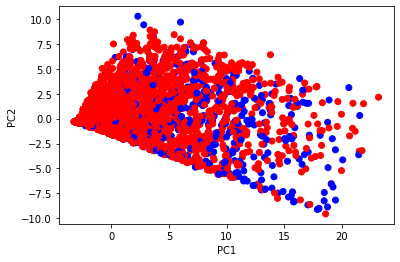

### Chi-Square Test of Independence.
#### We will try to check if there is a relationship between categorical variables.

*EMPLOYEES column
<br>
*PRODUCT_STAGE column


In [ ]:
ct1 = pd.crosstab(df.PRODUCT_STAGE, df.EMPLOYEES)
ct1

<style scoped> .dataframe tbody tr th:only-of-type { vertical-align: middle; }
.dataframe tbody tr th {
    vertical-align: top;
}

.dataframe thead th {
    text-align: right;
}
</style>

- We got
    - 1071.8373864739401 Chi-Square
    - p_vaule < 0.05
- We therefore see that there is a relationship between the variables and they are not independent
    - PRODUCT_STAGE column
    - EMPLOYEES column
- From chi square test we have learned that PRODUCT_STAGE and EMPLOYEES features that the higher number of employees is the higher the product stage is and the opposite claim is also true.

In [ ]:
df.to_csv('Data/companies_df/eda_df.csv', index=False)

## 5. Machine Learning 

In [ ]:
df = pd.read_csv('Data/companies_df/eda_df.csv')

### To start with the machine learning train and prediction, we need to convert our 4 status columns to 'is_successful' column.

#### 'SECTOR' and 'TARGET_INDUSTORY' are not ordinal categorical so we can give them codes in any order.

In [ ]:
sector_replace_map = dict( enumerate(df['SECTOR'].astype('category').cat.categories ))
sector_replace_map = dict([(value, key) for key, value in sector_replace_map.items()])
df['SECTOR'].replace(sector_replace_map, inplace=True)

target_replace_map = dict( enumerate(df['TARGET_INDUSTORY'].astype('category').cat.categories ))
target_replace_map = dict([(value, key) for key, value in target_replace_map.items()])
df['TARGET_INDUSTORY'].replace(target_replace_map, inplace=True)

#### We need to predict the ‘IS_SUCCESSFUL’ column. Let us separate it and assign it to a target variable ‘y’. The rest of the data frame will be the set of input variables X.

In [ ]:
y = df["IS_SUCCESSFUL"].values
x = df.drop(["IS_SUCCESSFUL"],axis=1)

#### Now let’s scale the predictor variables and then separate the training and the testing data.

In [ ]:
#Divide into training and test data
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0 ,test_size = 0.3) # 70% training and 30% test

## Logistic Regression

In [ ]:
clf = LogisticRegression(solver='lbfgs', max_iter=1000)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
acc = clf.score(X_test,y_test)
print(f"Accuracy of our model using logistic regression: {acc}")

#### Lets display our predicted result with confusion matrix

In [ ]:
y_predict = clf.predict(X_test)
cf_matrix = metrics.confusion_matrix(y_test, y_predict)

ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, fmt='g', ax=ax, cmap='Blues');  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); ax.set_title('Confusion Matrix'); ax.xaxis.set_ticklabels(['False','True']);ax.yaxis.set_ticklabels(['False','True']);

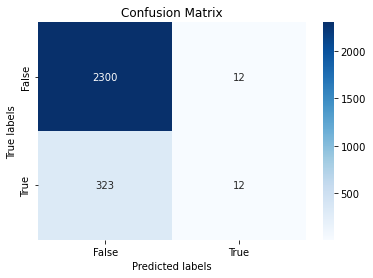

In [ ]:
print("accuracy is:",metrics.accuracy_score(y_test, y_predict))
print("precision is:",metrics.precision_score(y_test, y_predict))
print("recall is:",metrics.recall_score(y_test, y_predict))
print("f1 is:",metrics.f1_score(y_test, y_predict))

#### As we can see the results are not so great, lets try make some changes:

#### First, We found that 'TARGET_INDUSTORY' and 'FOUNDED_YEAR' features degrades model performance so we will drop them.

#### Second, We want to scale our 'RAISED' feature because it has very high values.

In [ ]:
df.drop(columns = ['TARGET_INDUSTORY'], axis=1, inplace=True)
df.drop(columns = ['FOUNDED_YEAR'], axis=1, inplace=True)

df[['RAISED']] = minmax_scale(df[['RAISED']])


y = df["IS_SUCCESSFUL"].values
x = df.drop(["IS_SUCCESSFUL"],axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0 ,test_size = 0.3) # 70% training and 30% test

clf = LogisticRegression(solver='lbfgs', max_iter=1000)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)


In [ ]:
ax= plt.subplot()
cf_matrix = metrics.confusion_matrix(y_test, y_predict)
sns.heatmap(cf_matrix, annot=True, fmt='g', ax=ax, cmap='Blues');  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); ax.set_title('Confusion Matrix'); ax.xaxis.set_ticklabels(['False','True']);ax.yaxis.set_ticklabels(['False','True']);

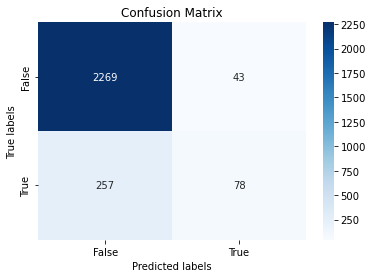

In [ ]:
print("accuracy is:",metrics.accuracy_score(y_test, y_predict))
print("precision is:",metrics.precision_score(y_test, y_predict))
print("recall is:",metrics.recall_score(y_test, y_predict))
print("f1 is:",metrics.f1_score(y_test, y_predict))

#### As we can see we got about 20-40% higher results!!!

## KNN - K-Nearest Neighbors

In [ ]:
# set up the model, k-NN classification with k = ?  
k = 3
clf = KNeighborsClassifier(n_neighbors=k)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

cf_matrix = metrics.confusion_matrix(y_true = y_test, y_pred = y_predict)

print('Accuracy = ', metrics.accuracy_score(y_true = y_test, y_pred = y_predict))


### Let us take a few possible values of k and fit the model on the training data for all those values. We will also compute the training score and testing score for all those values.

In [ ]:
train_score = []
test_score = []
k_vals = []

for k in range(1, 75):
    k_vals.append(k)
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    
    tr_score = knn.score(X_train, y_train)
    train_score.append(tr_score)
    
    te_score = knn.score(X_test, y_test)
    test_score.append(te_score)

print(f"Max train_score is: {max(train_score)}\nMax test_score is: {max(test_score)}")

In [ ]:
plt.figure(figsize=(10,5))
plt.xlabel('Different Values of K')
plt.ylabel('Model score')
plt.plot(k_vals, train_score, color = 'r', label = "training score")
plt.plot(k_vals, test_score, color = 'b', label = 'test score')
plt.legend(bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)
plt.show()


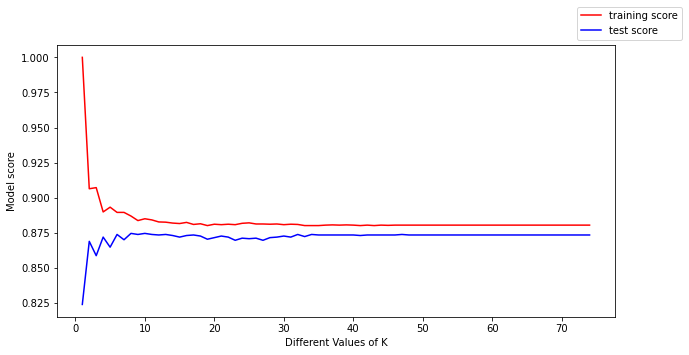

#### We found the best K for our model!
#### K = 10
#### Accuracy = 0.8745749905553457

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 10)

#Fit the model
knn.fit(X_train,y_train)

#get the score
knn.score(X_test,y_test)


We can make the following conclusions from the above plot:

    - For low values of k, the training score is high, while the testing score is low.
    - As the value of k increases, the testing score starts to increase and the training score starts to decrease.
    - However, the higher the value of k, both the training score and the testing score are close to each other.

## Decision Trees

In [ ]:
def splitData(df, features, labels, specifed_random_state=0):
    """Split a subset of the dataset, given by the features, into train and test sets."""
    df_predictors = df[features].values
    df_labels = df[labels].values

    # Split into training and test sets
    XTrain, XTest, yTrain, yTest = train_test_split(df_predictors, df_labels, random_state=specifed_random_state)
    return XTrain, XTest, yTrain, yTest

In [ ]:
def renderTree(my_tree, features):
    # hacky solution of writing to files and reading again
    # necessary due to library bugs
    filename = "temp.dot"
    with open(filename, 'w') as f:
        f = tree.export_graphviz(my_tree, 
                                 out_file=f, 
                                 feature_names=features, 
                                 class_names=["Perished", "Survived"],  
                                 filled=True, 
                                 rounded=True,
                                 special_characters=True)
  
    dot_data = ""
    with open(filename, 'r') as f:
        dot_data = f.read()

    graph = pydotplus.graph_from_dot_data(dot_data)
    image_name = "temp.png"
    graph.write_png(image_name)  
    display(Image(filename=image_name))

And here you can see the decision tree model with the prediction and accuracy of the training and testing of the model based on 'NEWS_COUNT' feature only.

In [ ]:
decisionTree = tree.DecisionTreeClassifier()
features = ['NEWS_COUNT']

XTrain, XTest, yTrain, yTest = splitData(df, features, ["IS_SUCCESSFUL"])
# fit the tree with the traing data
decisionTree = decisionTree.fit(XTrain, yTrain)

# predict with the training data
y_pred_train = decisionTree.predict(XTrain)
# measure accuracy
print('Accuracy on training data = ', 
      metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

# predict with the test data
y_pred = decisionTree.predict(XTest)
# measure accuracy
print('Accuracy on test data = ', 
      metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

renderTree(decisionTree, features)

Accuracy on training data =  0.8808767951625095
<br>
Accuracy on test data =  0.8739800543970988

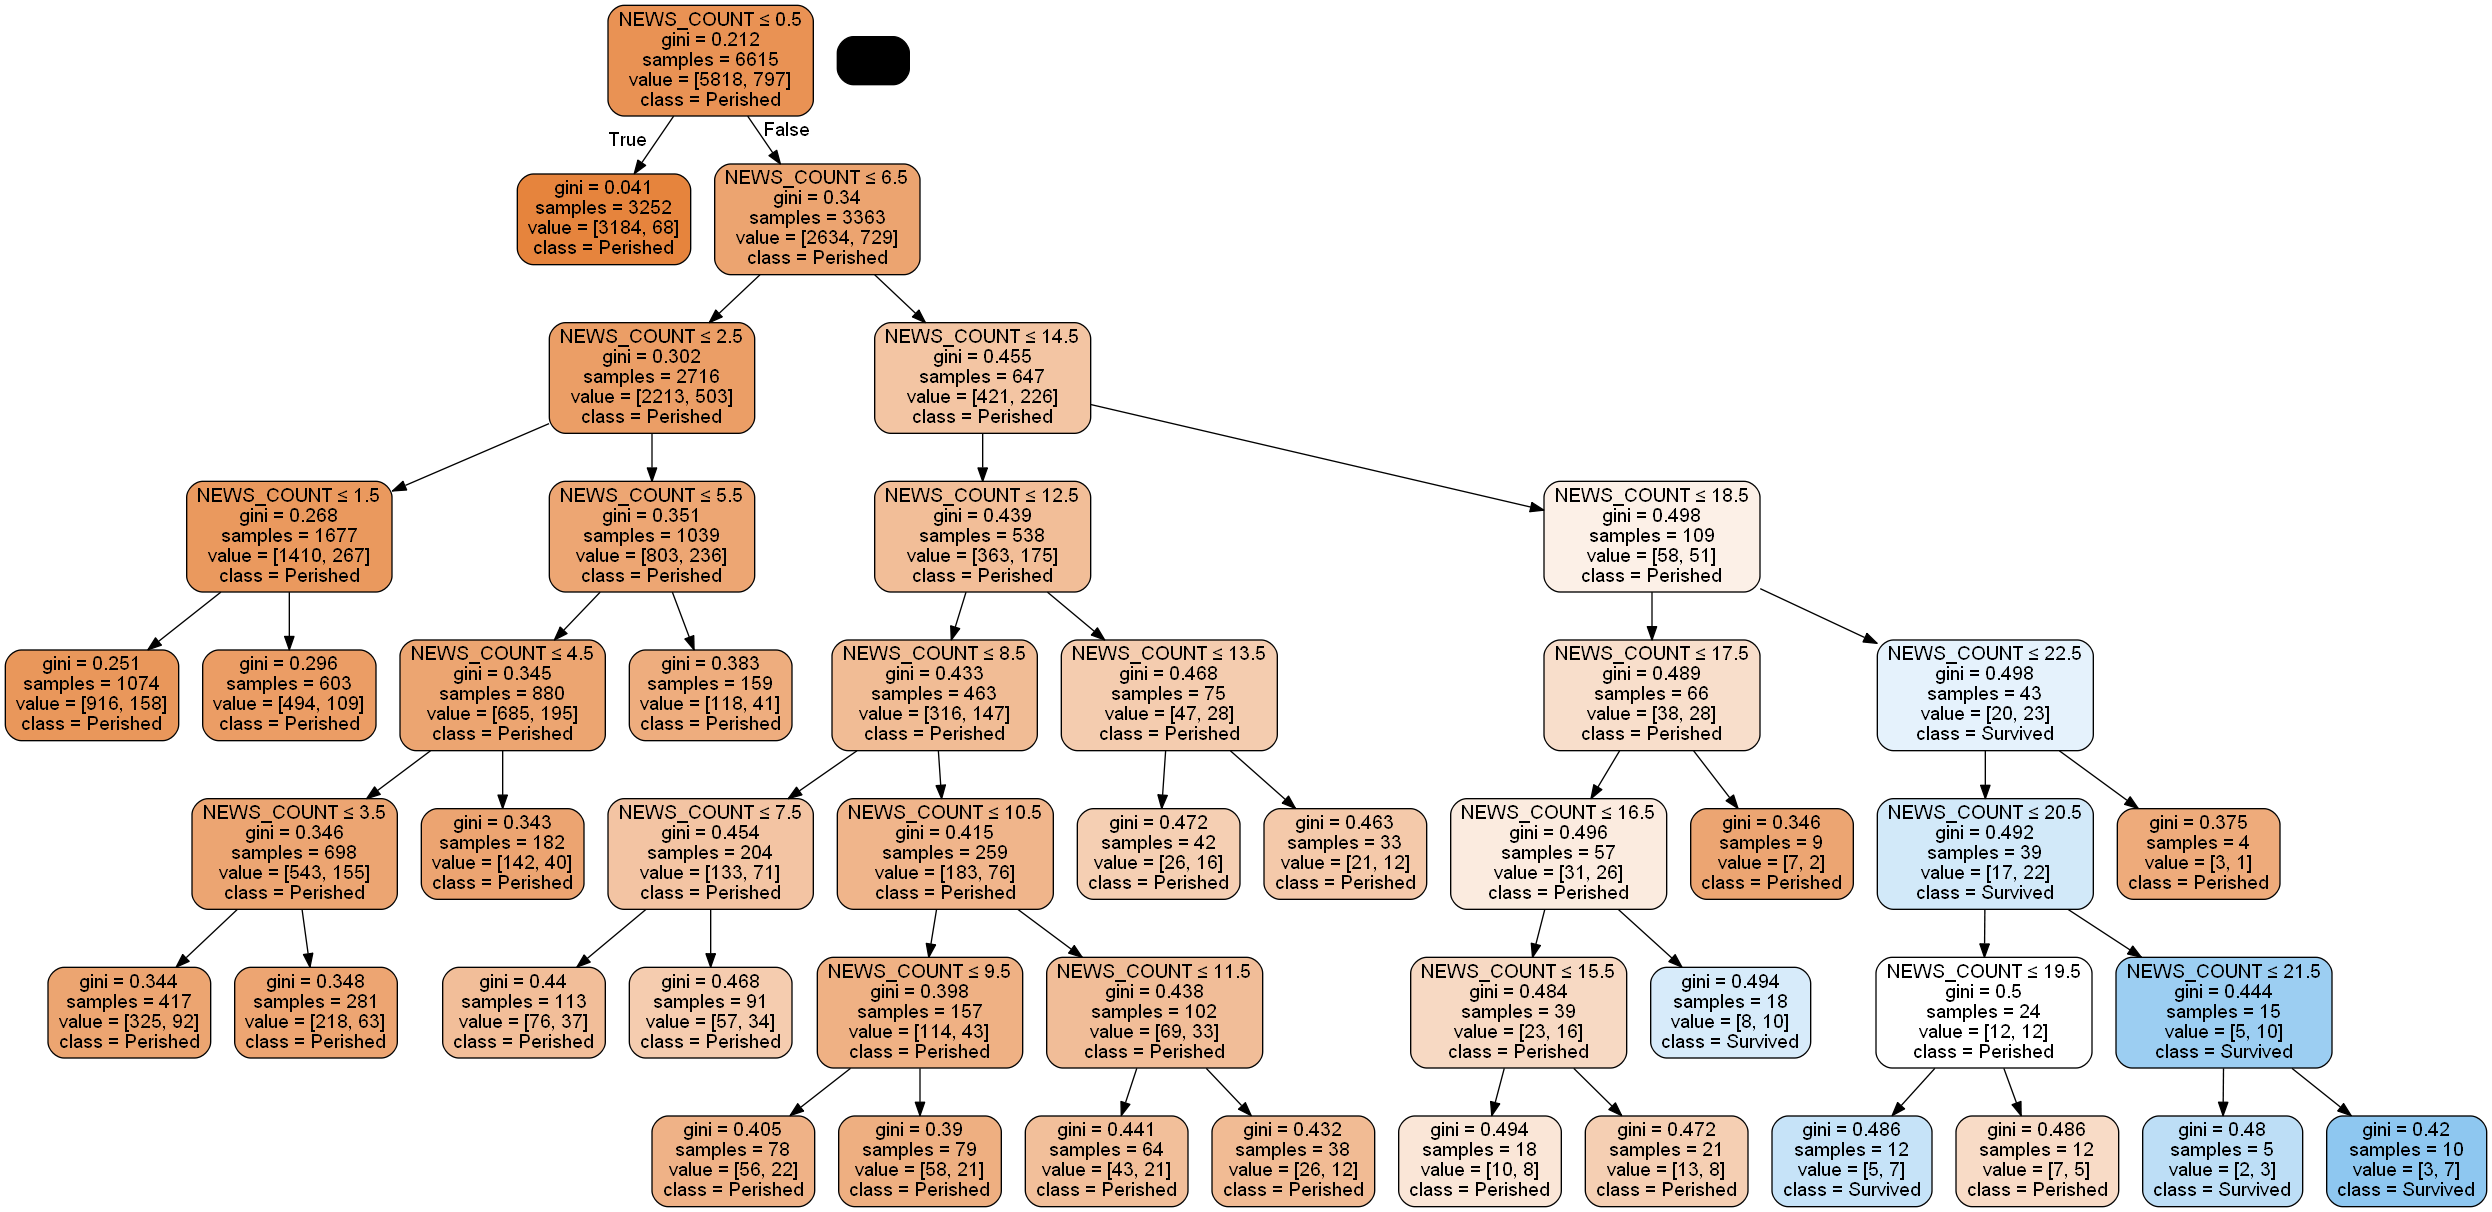

In [ ]:
decisionTree = tree.DecisionTreeClassifier()
all_features = df.columns.tolist()

all_features.remove('IS_SUCCESSFUL')

# fit the tree with the traing data
decisionTree = decisionTree.fit(X_train,y_train)

# predict with the training data
y_predict_train = decisionTree.predict(X_train)
# measure accuracy
print('Accuracy on training data = ', 
      metrics.accuracy_score(y_true = y_train, y_pred = y_predict_train))

# predict with the test data
y_predict = decisionTree.predict(X_test)
# measure accuracy
print('Accuracy on test data = ', 
      metrics.accuracy_score(y_true = y_test, y_pred = y_predict))

renderTree(decisionTree,all_features)

Accuracy on training data =  1.0
<br>
Accuracy on test data =  0.8617302606724594
<br>
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.899402 to fit



OK, clearly, we're overfitting the data - 100% accuracy on the training data and only ~86% on the test data. Yet, we've created a complicated tree.

In [ ]:
decisionTree = tree.DecisionTreeClassifier(max_depth=5, min_samples_split=20)
XTrain, XTest, yTrain, yTest = splitData(df, all_features, ["IS_SUCCESSFUL"])
decisionTree = decisionTree.fit(XTrain, yTrain)

y_pred_train = decisionTree.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

renderTree(decisionTree, all_features)


Accuracy on training data=  0.8946334089191232
<br>
Accuracy on test data=  0.8907524932003626
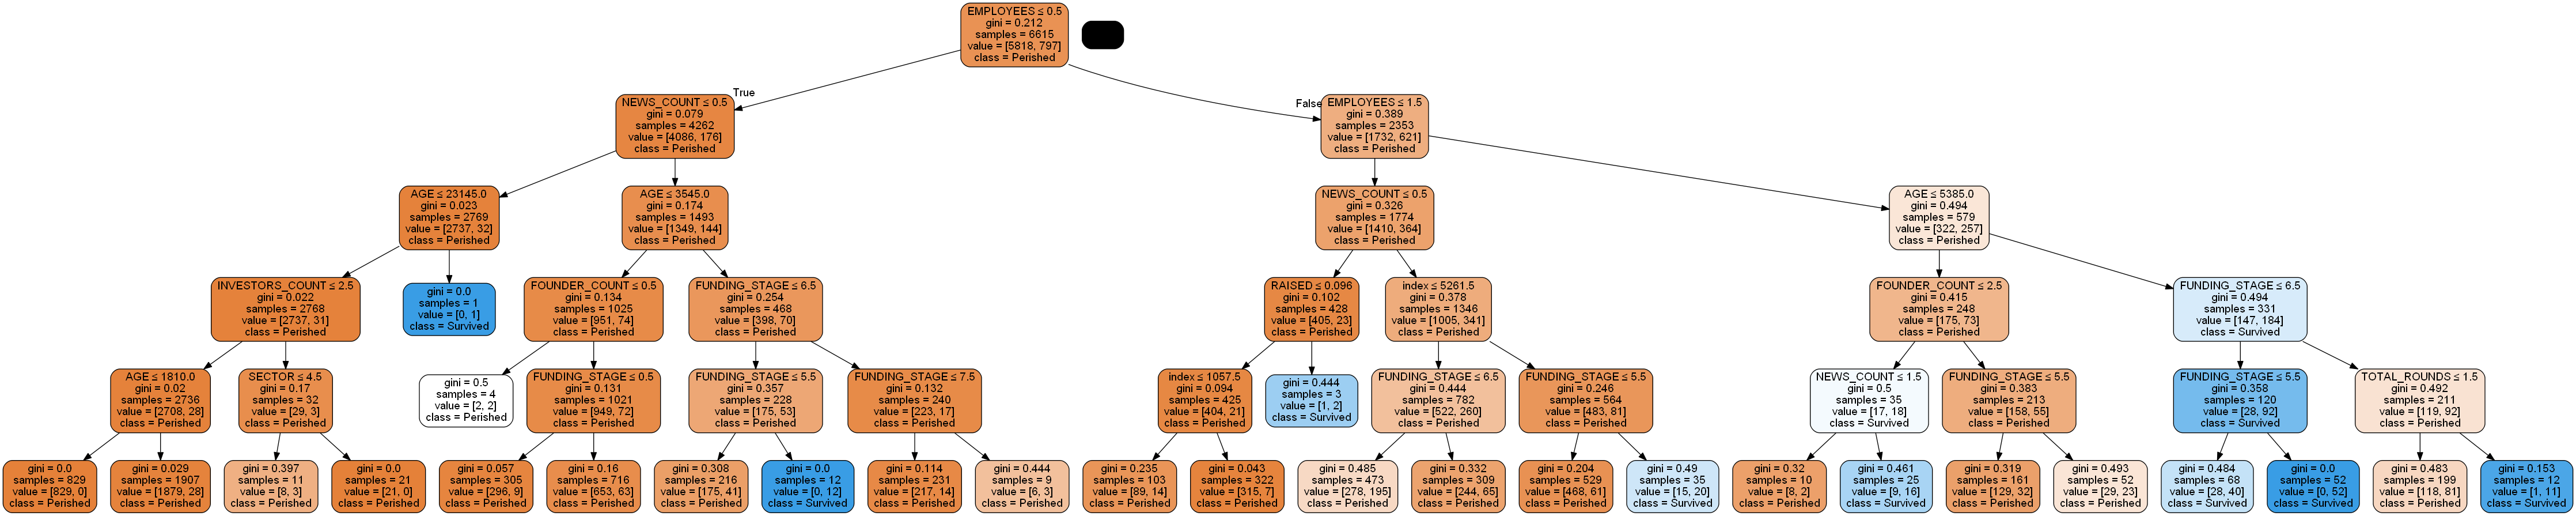
#### Slight improvement 89% for training and test without overfitting
We got ourselves a better training accuracy but the test prediction did not improve by a noticiable percentage.

## Naive Bayes

In [ ]:
# Split into training and test sets
y = df["IS_SUCCESSFUL"].values
x = df.drop(["IS_SUCCESSFUL"],axis=1)

XTrain, XTest, yTrain, yTest = train_test_split(x, y, random_state=0, test_size=0.25)


In [ ]:
# Instantiate the classifier
gnb = GaussianNB()

gnb.fit(XTrain,yTrain)

y_pred = gnb.predict(XTest)
y_pred_train = gnb.predict(XTrain)

# Print results
print('Accuracy on Train data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

Accuracy on Train data=  0.816780045351474
<br>
Accuracy on test data=  0.8250226654578422

In [ ]:
gnb.class_prior_


In [ ]:
array([0.87951625, 0.12048375])

We can see that only about 12% SUCCESSFUL..

## In conclusion, we have seen that the algorithms that have brought us the best results are Decision Trees and Logistic Regression with about 89% accuracy.

In [ ]:
df.to_csv('Data/companies_df/final_df.csv', index=False)